앞으로의 Test에서 시도해볼만 한 것!
* Kernel_size의 변화
* LSTM Layer 개수의 변화
* MaxPooling 사용
* GRU, LSTM Layer의 병렬적 사용
* Hidden State 개수의 변화
* Sequence 길이의 변화
* Bidirectional LSTM 대신 Bidirectional GRU 이용
* 합성곱층을 더욱 많이 사용

* 아래 함수는 `weather_localcenter_metadata`와 `weather_5minute_ASOS_2020-2023.parquet`, `holiday.csv`를 사용하여 5분 단위 기상대표값을 도출합니다.
* 본 모델링에서는 기상인자로 최고기온, 최저기온, 평균일사량 데이터를 사용하고자 합니다. 일사량의 결측치 비율을 최소화 하기 위해 울산시를 제외한 특별시 및 광역시 데이터를 사용하였으며 (울산시 일사량 데이터의 대부분이 결측치였음), 강원도의 기상 인자도 반영하기 위해 도내에서 가장 인구가 많은 도시인 원주를 포함하였습니다.
* 보간법을 적용하기 전의 기온과 일사량의 결측치 비율은 전체 대비 0.2%, 0.4% 수준이며, 선형보간법을 통해 결측치를 보완하고자 했습니다.
* 단순히 휴일여부가 아니라 어떤 휴일에 해당하는지를 더미변수로 추가해보았습니다. (휴일이 아닌 날, 신정, 설날, 삼일절, 선거일, 어린이날, 석가탄신일, 현충일, 광복절, 추석, 개천절, 기독탄신일, 한글날, 대체공휴일 등 총 14가지로 분류)

In [17]:
import random
import numpy as np
import torch

seed = 222
deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [2]:
def weather_data_5minute(weather_metadata_path, weather_5minute_ASOS_path, holiday_path):

  import pandas as pd

  # 기상관측 MetaData 불러오기
  weather_metadata = pd.read_csv(weather_metadata_path)
  STN_dict = {STN_name : STN_num for STN_num, STN_name in zip(weather_metadata['지점'], weather_metadata['지점명'])}
  target_STN_list = [STN_dict[STN_name] for STN_name in ['서울', '부산', '인천', '대구', '대전', '광주', '원주']]

  # 서울 포함 7개 도시의 기온 및 일사량 데이터 불러오기
  weather_5minute = pd.read_parquet(weather_5minute_ASOS_path).astype({'지점' : 'int'})
  weather_5minute = weather_5minute[weather_5minute['지점'].isin(target_STN_list)]
  weather_5minute = weather_5minute[['지점', '일시', '기온(°C)', '일사(MJ/m^2)']]
  weather_5minute.columns = ['지점', '일시', '기온', '일사']

  column_list = ['기온', '일사']

  # 선형보간법 사용하여 결측값 채우기
  for idx, STN in enumerate(target_STN_list):

      # ① 각 STN별로 데이터 나누기
      tmp = weather_5minute[weather_5minute['지점'] == STN]

      # ② 시간순으로 정렬하기
      tmp = tmp.sort_values(by='일시')

      # ③ 선형보간법을 사용하여 nan값 채우기                
      for column in column_list:
        tmp[column] = tmp[column].interpolate(method='linear')

      # ④ tmp 합치기
      if idx == 0:
        interpolated_weather = tmp
      else:
        interpolated_weather = pd.concat([interpolated_weather, tmp])

  # 전국 기상 대표값 정하기 (최고기온, 최저기온, 평균일사량)
  for idx, column in enumerate(column_list):
    if column == '기온':
      # 최고 기온
      tmp_1 = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)[column].max()).rename(columns = {'기온' : 'max_temp'})
      # 최저 기온
      tmp_2 = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)[column].min()).rename(columns = {'기온' : 'min_temp'})
      tmp = pd.merge(tmp_1, tmp_2, on = '일시', how = 'inner')
    else:
      # 평균 일사량
      tmp = pd.DataFrame(interpolated_weather.groupby('일시', as_index = False)[column].mean()).rename(columns = {'일사' : 'mean_insolation'})
    # ② groupby 결과를 인덱스 기준으로 Join
    if idx == 0:
      representative_weather = tmp
    else:
      representative_weather = pd.merge(representative_weather, tmp, on = '일시', how = 'inner')

  representative_weather.rename(columns = {'일시' : 'datetime'}, inplace= True)

  # 요일 특성 반영 (더미변수로 반영)
  # 0 : 월요일, 1 : 화요일 ~ 금요일, 2 : 토요일, 3 : 일요일

  representative_weather['weekday'] = pd.to_datetime(representative_weather['datetime']).dt.weekday
  representative_weather.replace({'weekday' : {2 : 1, 3 : 1, 4 : 1, 5 : 2, 6 : 3}}, inplace = True)
  representative_weather = pd.get_dummies(representative_weather, columns = ['weekday'])
                                          
  # 휴일 유형에 맞춘 더미변수 반영

  holiday = pd.read_csv(holiday_path)

  for dateName in ['국회의원선거일', '대통령선거일', '동시지방선거일', '전국동시지방선거', '제21대 국회의원선거']:
    holiday.replace({'dateName' : {dateName : '선거일'}}, inplace = True)
  holiday.replace({'dateName' : {'1월1일' : '신정'}}, inplace = True)
  holiday.replace({'dateName' : {'부처님오신날' : '석가탄신일'}}, inplace = True)
  holiday.replace({'dateName' : {'어린이 날' : '어린이날'}}, inplace = True)
  holiday.replace({'dateName' : {'대체휴무일' : '대체공휴일'}}, inplace = True)
  holiday.replace({'dateName' : {'임시공휴일' : '대체공휴일'}}, inplace = True)

  nameToNumber = {dateName : idx + 1  for idx, dateName in enumerate(list(holiday['dateName'].unique()))}
  holiday.replace({'dateName' : nameToNumber}, inplace = True)
  holiday_dict = {locdate : dateName for dateName, locdate in zip(holiday['dateName'], holiday['locdate'])}

  for row_number in range(representative_weather.shape[0]):
    if representative_weather.at[row_number, 'datetime'][:-6] in list(holiday['locdate']):
      representative_weather.at[row_number, 'holiday'] = holiday_dict[representative_weather.at[row_number, 'datetime'][:-6]]
    else:
      representative_weather.at[row_number, 'holiday'] = 0

  representative_weather = pd.get_dummies(representative_weather, columns = ['holiday'])

  # 월, 시간 정보 반영 (더미변수로 반영)

  representative_weather['month'] = pd.to_datetime(representative_weather['datetime']).dt.month
  representative_weather = pd.get_dummies(representative_weather, columns = ['month'])
  representative_weather['hour'] = pd.to_datetime(representative_weather['datetime']).dt.hour
  representative_weather = pd.get_dummies(representative_weather, columns = ['hour'])

  return representative_weather

In [3]:
# 기상대표값 데이터 생성하기

weather_metadata_path = '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/weather/weather_localcenter_metadata.csv'
weather_5minute_ASOS_path = '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/weather/ASOS (2020-2023)/weather_5minute_ASOS_2020-2023.parquet'
holiday_path = '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/time/holidays.csv'
representative_weather = weather_data_5minute(weather_metadata_path, weather_5minute_ASOS_path, holiday_path)

전력 데이터는 지호님이 완성해주신 `power_demand_interpolated`를 사용하였습니다.

In [4]:
# 전력 데이터 불러오기

import pandas as pd

power = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/load_supply/power_demand_interpolated.csv')
power.columns = ['datetime', 'load']

기상인자 대표값과 보간 처리된 전력데이터를 일시를 기준으로 Inner Join합니다.

In [5]:
# 전력 데이터와 기상인자 데이터 합치기
# 2023년 3월 19일까지의 데이터로 한정

target_df = pd.merge(representative_weather, power, on = 'datetime', how = 'inner')[:-288]

Custom Dataset과 Dataloader를 사용하여 메모리 사용량을 줄였습니다.

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, target_df, binary_var_start_number, scaler_for_X, scaler_for_Y, seq_len, step_len, stride):
    self.dataset_tensor =torch.FloatTensor(np.array(pd.concat([pd.DataFrame(scaler_for_X.fit_transform(target_df.iloc[:,1:binary_var_start_number])),
                                                               target_df.iloc[:,binary_var_start_number:-1],
                                                               pd.DataFrame(scaler_for_Y.fit_transform(np.array(target_df['load']).reshape(-1, 1)))], axis = 1))).cuda()                           
    self.data_size = (self.dataset_tensor.shape[0] - step_len - seq_len) // stride
    self.seq_len = seq_len
    self.step_len = step_len
    self.stride= stride
  
  def __len__(self):
    return self.data_size
  
  def __getitem__(self, idx):
    return self.dataset_tensor[idx*self.stride :idx*self.stride + self.seq_len, :], self.dataset_tensor[idx*self.stride + self.seq_len : idx*self.stride + self.seq_len + self.step_len, -1]

# Scaler 객체 생성
ss_1 = MinMaxScaler() # Scaler for X
ss_2 = MinMaxScaler() # Scaler for y

# CustomDataset 파라미터 설정 (Scaler 객체, 시퀀스의 길이, 스텝 사이즈, 건너뛸 간격)
seq_len = 2016 # 시퀀스의 길이
step_len = 72 # 스텝 사이즈 (추정하고자 하는 값의 개수)
stride = 1 # 건너뛸 간격

# target_df를 train_df와 test_df로 분리
# target_df는 예측 대상 기간인 2023년 3월 13일부터 19일 + Sequence의 길이만큼의 데이터를 담음
test_df = target_df.iloc[-1 * (seq_len + 2016):,:]
train_df = target_df.iloc[:-1 * (seq_len + 2016),:]

# 데이터셋 생성
train_dataset = CustomDataset(train_df, 4, ss_1, ss_2, seq_len, step_len, stride)

# 데이터 로더 생성
train_dataloader = DataLoader(train_dataset, batch_size = 256, shuffle = True, drop_last = True)

In [7]:
import torch.nn as nn

# CNN + 양방향 LSTM 모델 구성하기

in_channels = 58 # 입력 컬럼의 개수
out_channels = 116 # 합성곱 필터로 생성될 out의 Dimension = 필터의 개수
hidden_dim = 288 # 은닉 상태의 개수
output_dim = 72 # 출력 값의 개수(형태)
learning_rate = 0.0001 # 학습률
nb_epochs = 30 # 에포크의 수
seq_length = 2016 # sequence의 길이 (얼마간의 데이터가 들어오는가)

class CNN_BILSTM(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers):
    super(CNN_BILSTM, self).__init__()
    # 입력인자 정의
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.hidden_dim = hidden_dim
    self.seq_len = seq_len
    self.output_dim = output_dim
    self.layers = layers
    # 합성곱 Layer 정의
    self.conv1d = nn.Conv1d(in_channels = self.in_channels, 
                            out_channels = self.out_channels,
                            kernel_size = self.kernel_size, 
                            padding = 'same')
    # LSTM Layer 정의
    self.lstm = nn.LSTM(self.out_channels, 
                        self.hidden_dim, 
                        num_layers = self.layers, 
                        batch_first = True, 
                        bidirectional = True)
    # 완전연결층 정의
    self.fc = nn.Linear(hidden_dim * 2, output_dim, bias = True)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.layers, self.seq_len, self.hidden_dim),
        torch.zeros(self.layers, self.seq_len, self.hidden_dim)
        )
  
  # 결과값 계산
  def forward(self, x):
    x = torch.transpose(x, 1, 2)
    x = self.conv1d(x)
    x = torch.transpose(x, 1, 2)
    x, _status = self.lstm(x)
    x = self.fc(x[:, -1])
    return x

In [8]:
!pip install torchmetrics -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.0 MB/s eta 0:00:00


In [9]:
# 모델 학습 함수 만들기

# !pip install torchmetrics
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
from torchmetrics import MeanAbsolutePercentageError

def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  nb_epochs = num_epochs
  mean_abs_percentage_error = MeanAbsolutePercentageError().to(device)

  # epoch마다 loss 저장
  train_hist = np.zeros(nb_epochs)
  output = []
  
  for epoch in range(nb_epochs):
    avg_cost = 0
    total_batch = len(train_df)
    for batch_idx, samples in enumerate(train_df):
      x_train, y_train = samples
      # seq별 hidden state reset
      model.reset_hidden_state()
      # H(x) 계산
      outputs = model(x_train)
      # cost 계산
      loss = mean_abs_percentage_error(outputs, y_train)
      # cost로 H(x) 개선
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      avg_cost += loss/total_batch 

    train_hist[epoch] = avg_cost

    if epoch % verbose == 0:
      print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
    # patience번째 마다 early stopping 여부 확인
    if (epoch % patience == 0) & (epoch != 0):
      if train_hist[epoch-patience] < train_hist[epoch]:
        print('\n Early Stopping')
        break
  
  return model.eval(), train_hist

In [ ]:
# 커널 사이즈가 3인 CNN + 양방향 LSTM 모델 학습 (Bidirectional LSTM layer를 2개로 설정하였습니다.)
# 입력해야할 인자 : in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers):

kernel_size = 3 # 합성곱 필터의 kernel_size

cnn_bilstm = CNN_BILSTM(in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers = 2).to(device)
cnn_bilstm_model_kernel_3, cnn_bilstm_hist = train_model(cnn_bilstm, train_dataloader, num_epochs = nb_epochs,
                                                         lr = learning_rate, verbose = 1, patience = 4)
torch.save(cnn_bilstm_model_kernel_3, '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/modeling/모델링 결과/model_20230526_CNN-BILSTM_kernel3.pth')

In [ ]:
# 커널 사이즈가 5인 CNN + 양방향 LSTM 모델 학습 (Bidirectional LSTM layer를 2개로 설정하였습니다.)
# 입력해야할 인자 : in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers):

kernel_size = 5 # 합성곱 필터의 kernel_size

cnn_bilstm = CNN_BILSTM(in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers = 2).to(device)
cnn_bilstm_model_kernel_5, cnn_bilstm_hist = train_model(cnn_bilstm, train_dataloader, num_epochs = nb_epochs,
                                                         lr = learning_rate, verbose = 1, patience = 4)
torch.save(cnn_bilstm_model_kernel_5, '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/modeling/모델링 결과/model_20230529_CNN-BILSTM_kernel5.pth')

In [ ]:
# 커널 사이즈가 7인 CNN + 양방향 LSTM 모델 학습 (Bidirectional LSTM layer를 2개로 설정하였습니다.)
# 입력해야할 인자 : in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers):

kernel_size = 7 # 합성곱 필터의 kernel_size

cnn_bilstm = CNN_BILSTM(in_channels, out_channels, kernel_size, hidden_dim, seq_len, output_dim, layers = 2).to(device)
cnn_bilstm_model_kernel_7, cnn_bilstm_hist = train_model(cnn_bilstm, train_dataloader, num_epochs = nb_epochs,
                                                         lr = learning_rate, verbose = 1, patience = 4)
torch.save(cnn_bilstm_model_kernel_7, '/content/drive/MyDrive/Colab Notebooks/electricity_load_prediction/modeling/모델링 결과/model_20230529_CNN-BILSTM_kernel7.pth')

In [ ]:
# 저장된 모델 불러오기

base_path = '저장경로'
cnn_bilstm_model_kernel_3 = torch.load(base_path + 'model_20230526_CNN-BILSTM_kernel3.pth')
cnn_bilstm_model_kernel_5 = torch.load(base_path + 'model_20230529_CNN-BILSTM_kernel5.pth')
cnn_bilstm_model_kernel_7 = torch.load(base_path + 'model_20230529_CNN-BILSTM_kernel7.pth')

In [25]:
# model_test (CNN + Bidirectional Model)

# 커스텀데이터셋 클래스 정의하기

class CustomDatasetForTest(torch.utils.data.Dataset):
  def __init__(self, target_df, binary_var_start_number, scaler_for_X, scaler_for_Y, seq_len, step_len, stride):
    self.dataset_tensor =torch.FloatTensor(np.array(pd.concat([pd.DataFrame(scaler_for_X.transform(target_df.iloc[:,1:binary_var_start_number])),
                                                               target_df.iloc[:,binary_var_start_number:-1].reset_index(drop = True),
                                                               pd.DataFrame(scaler_for_Y.transform(np.array(target_df['load']).reshape(-1, 1)))], axis = 1))).cuda()                           
    self.data_size = (self.dataset_tensor.shape[0] - step_len - seq_len) // stride
    self.seq_len = seq_len
    self.step_len = step_len
    self.stride= stride
  
  def __len__(self):
    return self.data_size
  
  def __getitem__(self, idx):
    return self.dataset_tensor[idx*self.stride :idx*self.stride + self.seq_len, :], self.dataset_tensor[idx*self.stride + self.seq_len : idx*self.stride + self.seq_len + self.step_len, -1]

# 데이터셋 및 데이터로더 객체 선언하기

test_dataset = CustomDatasetForTest(test_df, 4, ss_1, ss_2, seq_len, step_len, stride)
test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle = False, drop_last = True)

with torch.no_grad():

  # 예측값과 실제값을 담을 빈 리스트 준비하기

  cnnbi_pred_list_kernel_3 = []
  cnnbi_pred_list_kernel_5 = []
  cnnbi_pred_list_kernel_7 = []
  cnnbi_true_list = []

  for X, y in test_dataloader:

    # 데이터 로더에서 테스트 데이터 꺼내기
    X = X.to(device)
    y = y.to(device)

    # 모델별 예측값 계산
    pred_kernel_3 = cnn_bilstm_model_kernel_3(X)
    pred_kernel_5 = cnn_bilstm_model_kernel_5(X)
    pred_kernel_7 = cnn_bilstm_model_kernel_7(X)

    # 모델별 예측값 및 실제값을 리스트에 넣어주기
    cnnbi_pred_list_kernel_3.append(ss_2.inverse_transform(pred_kernel_3.cpu().detach().numpy()))
    cnnbi_pred_list_kernel_5.append(ss_2.inverse_transform(pred_kernel_5.cpu().detach().numpy()))
    cnnbi_pred_list_kernel_7.append(ss_2.inverse_transform(pred_kernel_7.cpu().detach().numpy()))
    cnnbi_true_list.append(ss_2.inverse_transform(y.cpu().detach().numpy()))

# 위에서 완성된 예측값, 실제값 리스트로 평균 MAPE 계산하기
cnnbi_MAPE_list_kernel_3 = [np.mean(np.abs(pred - true)/true) for pred, true in zip(cnnbi_pred_list_kernel_3, cnnbi_true_list)]
cnnbi_MAPE_list_kernel_5 = [np.mean(np.abs(pred - true)/true) for pred, true in zip(cnnbi_pred_list_kernel_5, cnnbi_true_list)]
cnnbi_MAPE_list_kernel_7 = [np.mean(np.abs(pred - true)/true) for pred, true in zip(cnnbi_pred_list_kernel_7, cnnbi_true_list)]

# 모델별 평균 MAPE 출력하기
print('커널 사이즈가 3인 CNN + Bi-LSTM 모델의 전체 평균 MAPE는 {}% 입니다'.format(round(sum(cnnbi_MAPE_list_kernel_3)/len(cnnbi_MAPE_list_kernel_3) * 100, 3)))
print('커널 사이즈가 5인 CNN + Bi-LSTM 모델의 전체 평균 MAPE는 {}% 입니다'.format(round(sum(cnnbi_MAPE_list_kernel_5)/len(cnnbi_MAPE_list_kernel_5) * 100, 3)))
print('커널 사이즈가 7인 CNN + Bi-LSTM 모델의 전체 평균 MAPE는 {}% 입니다'.format(round(sum(cnnbi_MAPE_list_kernel_7)/len(cnnbi_MAPE_list_kernel_7) * 100, 3)))

커널 사이즈가 3인 CNN + Bi-LSTM 모델의 전체 평균 MAPE는 1.879% 입니다
커널 사이즈가 5인 CNN + Bi-LSTM 모델의 전체 평균 MAPE는 1.684% 입니다
커널 사이즈가 7인 CNN + Bi-LSTM 모델의 전체 평균 MAPE는 1.782% 입니다


### **금일 모델링에 대한 정리**

#### **모델 상세 - 1D CNN + 양방향 LSTM**

* 합성곱 커널 사이즈 : 5, 7
* 합성곱 필터의 개수 : 116
* LSTM Layer의 개수 : 2개 (양방향 LSTM Layer)
* Hidden State의 개수 : 288개
* Sequence의 길이 : 2016개 (1일당 5분 간격 데이터 288개 * 일주일)
* Input Dimension(사용한 컬럼의 개수) : 58개

|분류|사용변수|
|---|---|
|기상인자 (3개) |최고기온, 최저기온, 평균일사량|
|달력정보 (54개) |요일특성(Dummy, 4개), 휴일유형 (Dummy, 14개), 월(Dummy, 12개), 시간(Dummy, 24개)|
|전력수요 (1개)|5분당 전력수요|

* 학습시간 : 약 2시간 51분 (30 epoch 학습)
* Train, Test 데이터를 미리 분리한 후, Train 데이터셋에만 Scaler를 Fit-Transform하여 학습하고 테스트 시에 Scaler로 Transform만 진행하여 Test 진행
* **TEST_MAPE**
  * **Kernel size 3 : 1.879%**
  * **Kernel size 5 : 1.684%**
  * **Kernel size 7 : 1.782%**

#### **발견한 점**

* kernel size가 5일 때 예측 성능이 가장 좋았으며, 7인 경우에는 3인 경우보다는 좋았지만 5인 경우보다는 높았다.
* 더 많은 경우를 테스트해봐야 알 수 있겠지만, kernel size가 5인 경우에 최적을 이루고 양쪽으로 진행할 수록 성능이 나빠질 것이라고 추정할 수 있다.
* 매 배치마다 MAPE를 측정한 것을 그래프로 확인한 결과, kernel size가 5인 경우에 진폭이 좁혀짐을 알 수 있었다.

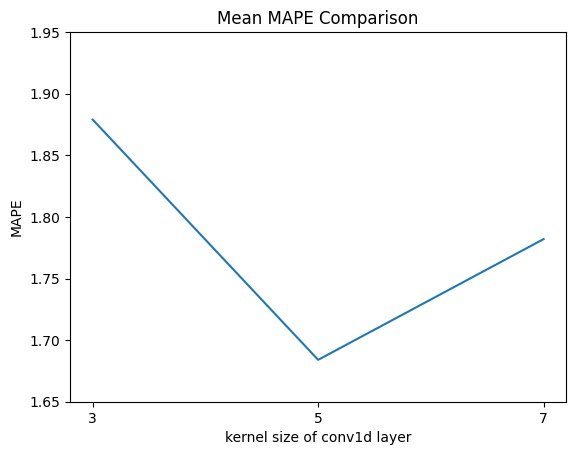

In [56]:
import matplotlib.pyplot as plt

plt.plot([3, 5, 7], [round(sum(cnnbi_MAPE_list_kernel_3)/len(cnnbi_MAPE_list_kernel_3) * 100, 3),
                     round(sum(cnnbi_MAPE_list_kernel_5)/len(cnnbi_MAPE_list_kernel_5) * 100, 3),
                     round(sum(cnnbi_MAPE_list_kernel_7)/len(cnnbi_MAPE_list_kernel_7) * 100, 3)])
plt.title('Mean MAPE Comparison')
plt.yticks([1.5 + i * 0.05 for i in range(3, 10)])
plt.ylabel('MAPE')
plt.xticks([3, 5, 7])
plt.xlabel('kernel size of conv1d layer')
plt.show()

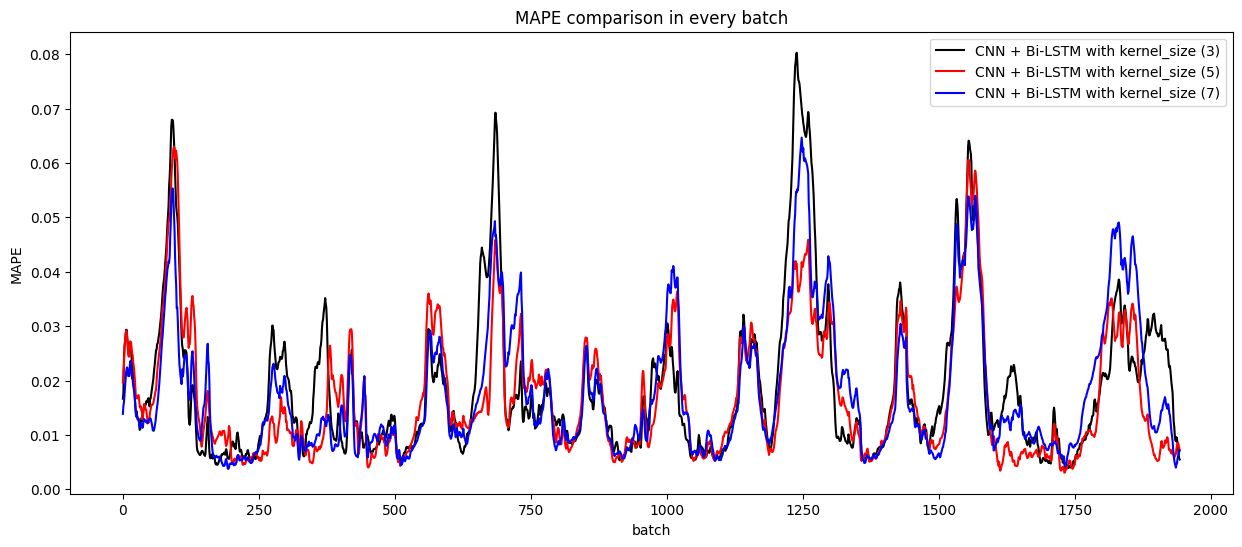

In [55]:
# 커널 사이즈가 다른 두 CNN+Bi-LSTM 모델의 성능 비교 

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (15,6))
plt.plot(cnnbi_MAPE_list_kernel_3, label = 'CNN + Bi-LSTM with kernel_size (3)', color = 'black')
plt.plot(cnnbi_MAPE_list_kernel_5, label = 'CNN + Bi-LSTM with kernel_size (5)', color = 'red')
plt.plot(cnnbi_MAPE_list_kernel_7, label = 'CNN + Bi-LSTM with kernel_size (7)', color = 'blue')
plt.title('MAPE comparison in every batch')
plt.xlabel('batch')
plt.ylabel('MAPE')
plt.legend()
plt.show()